# Kernel convergence

## Preamble
This notebook demonstrates convergence of the graph Matern kernel to the Riemannian Matern kernel (Figure 2 in the paper).

Here we take a sphere and triangulate it, thus obtaining a triangular mesh, whereupon we consider a graph Matern kernel.
The graph kernel converges to the Riemannian kernel as the number of triangles increases.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib import cm, colors
from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
import networkx as nx

import numpy as np
import scipy

In [2]:
import stripy

In [3]:
from spharapy import trimesh as tm
from spharapy import spharabasis as sb

In [4]:
np.random.seed(1234)

## Compute the Riemanian kernel
We compute the Riemannian kernel by approximating it taking `num_feat = 512` eigenpairs.

In [5]:
def sphere(r=1., nlats=101, nlons=101, center=None):
    if center is None:
        center = np.r_[0, 0, 0]
    phi, theta = np.mgrid[0:np.pi:nlats*1j, 0:2 * np.pi:nlons*1j]

    x = r * np.sin(phi) * np.cos(theta) + center[0]
    y = r * np.sin(phi) * np.sin(theta) + center[1]
    z = r * np.cos(phi) + center[2]
    
    return x, y, z

In [6]:
# Create a sphere
x, y, z = sphere()

In [7]:
# construct true kernel
gamma = scipy.special.gamma
leg = scipy.special.eval_legendre

num_feat = 512
n = np.arange(num_feat) + 1
true_eigvals = n * (n+1)
dn = (2*n + 1)  # Gammas cancel out
cn = dn * 2 / (np.sqrt(2) * np.pi * leg(n, np.ones_like(n)))

nu = 1.5
kappa = 2.0

def true_kernel(x, x2):
    psd = np.power(2*nu/kappa**2 + true_eigvals, -(nu))[None, :]  # (1, l)
    c_nu = np.sum(psd * cn) # (1,)
    
    cos_geo_dist = np.sum(x * x2, axis=-1)[:, None]
    
    eigf = leg(n[None, :], cos_geo_dist)
    
    k = 1.0/c_nu * np.sum(psd * cn[None, :] * eigf, axis=-1)
    return k

Plot the true kernel

In [8]:
cmap = plt.get_cmap('plasma')

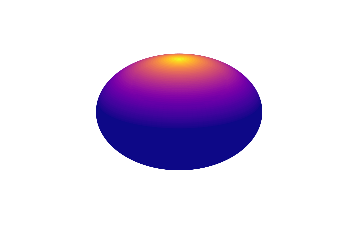

In [9]:
ax=plt.subplot(111, projection='3d')

x0 = np.c_[0, 0, 1]  # the North pole
x1 = np.c_[x.ravel(), y.ravel(), z.ravel()]

true_kernel_values = true_kernel(x0, x1)

surf = ax.plot_surface(x, y, z, 
                       cstride=1, rstride=1, 
                       cmap=cmap,
                       facecolors=cmap(true_kernel_values.reshape(x.shape)))
ax.set_axis_off()

## Compute the graph kernel
Construct an icosahedral mesh and compute the graph kernel on it.

In [10]:
def construct_mesh_approximation(level=2):
    
    rmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=level)
    
    G = nx.Graph()
    for s in rmesh.simplices:
        nx.add_path(G, s)
      
    # laplacian fem eigenbasis
    smesh = tm.TriMesh(rmesh.simplices, rmesh.points)
    sb_fem = sb.SpharaBasis(smesh, mode='fem')

    eigfun, eigvals = sb_fem.basis()

    # discard 0 eigenvalue
    eigvecs = eigfun[:, 1:num_feat+1]
    eigvals = eigvals[1:num_feat+1]
    
    return rmesh, eigvecs, eigvals, G

In [11]:
def compute_graph_kernel_values(eigvecs, eigvals, G):
    kernel = GraphMaternKernel((eigvecs, eigvals), nu=nu, kappa=kappa)
    
    id0 = np.r_[0][None, :]
    ids = np.arange(G.number_of_nodes())[:, None]

    kernel_vals = kernel.K(id0, ids)
    kernel_vals = kernel_vals.numpy().squeeze() / np.max(kernel_vals)
    
    return kernel_vals

The graph kernel values are then piecewise-constantly interpolated onto the sphere (for the sake of visualization).

In [12]:
def compute_voronoi_diagram(rmesh):
    voronoi = scipy.spatial.SphericalVoronoi(rmesh.points)
    voronoi.sort_vertices_of_regions()
    return voronoi

In [13]:
def set_plot_params(ax, lim=0.65):
    ax.set_axis_off()
    # lim = 0.6
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim) 

In [14]:
def plot_3d_graph(ax, rmesh, G):
    ax.scatter(rmesh.points[:, 0], rmesh.points[:, 1], rmesh.points[:, 2], s=2.0, c='tab:red')
    
    edge_collection = []
    for edge in G.edges:
        start, end = edge
        edge_collection.append(np.c_[rmesh.points[start], rmesh.points[end]].T)      
    coll = Line3DCollection(edge_collection, linewidths=0.2)
    
    ax.add_collection3d(coll)         

In [15]:
def plot_spherical_voronoi(ax, voronoi, facecolors):
    verts=[]
    for k, region in enumerate(voronoi.regions):
        vert = voronoi.vertices[region]
        verts.append(vert)
    coll = Poly3DCollection(verts, linewidth=0.00001)
    coll.set_facecolor(facecolors)
   
    ax.add_collection3d(coll)    

## Plot the results

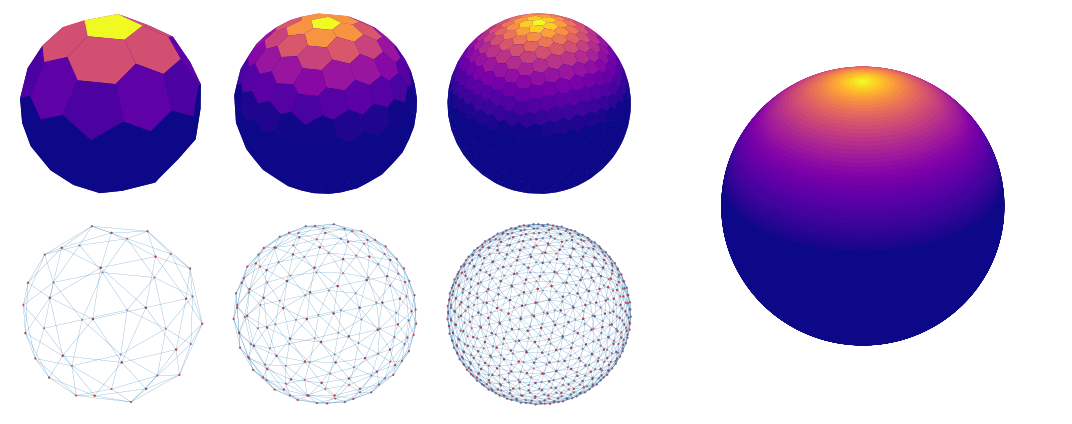

In [16]:
nrows = 2
ncols = 5

fig=plt.figure(figsize=(ncols*3, nrows*3))
gridspec = fig.add_gridspec(nrows, ncols)

ax=plt.subplot(gridspec[:, -2:], projection='3d')
surf = ax.plot_surface(x, y, z, 
                       cstride=1, rstride=1, 
                       cmap = cmap,
                       facecolors=cmap(true_kernel_values.reshape(x.shape)))
set_plot_params(ax, lim=0.8)

levels = [1, 2, 3]

for i, level in enumerate(levels):
    rmesh, eigvecs, eigvals, G = construct_mesh_approximation(level)
    kernel_vals = compute_graph_kernel_values(eigvecs, eigvals, G)
    voronoi = compute_voronoi_diagram(rmesh)

    ax = plt.subplot(gridspec[0, i], projection='3d')
    plot_spherical_voronoi(ax, voronoi, cmap(kernel_vals))
    set_plot_params(ax)

    ax = plt.subplot(gridspec[1, i], projection='3d')
    plot_3d_graph(ax, rmesh, G)
    set_plot_params(ax)

plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout()